## Digital-analog variational quantum eigensolver(DAVQE)


In [44]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_nature
!pip install qutip
!pip install pyscf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from DA_VQE import *

This notebook is aimed to solve the ground state energy of the hydrogen molecule by using Digital-analog variational quantum eigensolver(DA-VQE). In conventional VQE, entanglement of qubits is performed by the digital control gates such as CX gates.

DA-VQE, on the other hand, employs a time-evolution operator $U(t) = e^{iH't}$. $H'$ usually consists of the two-spin interactions, which is distinct from the target Hamiltonian $H$ for optimization.


First, we define the two-qubit hamiltonian $H$.

In [45]:
LiH_op, LiH_problem, LiH_converter = load_Molecule("LiH")
print(f'Number of qubits: {LiH_op.num_qubits}')
ref_value = energy_solver(LiH_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(LiH_problem, LiH_converter)
print(f'Total energy: {ref_value:.5f}')

The atomic distance is  1.545 Å
Number of qubits: 4
Bonding energy value: -8.89100
Total energy: -7.86347


In [46]:
H2_op, H2_problem, H2_converter = load_Molecule("H2")
print(f'Number of qubits: {H2_op.num_qubits}')
ref_value = energy_solver(H2_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(H2_problem, H2_converter)
print(f'Total energy(core repulsion included): {ref_value:.5f}')

The atomic distance is  0.735 Å
Number of qubits: 2
Bonding energy value: -1.85728
Total energy(core repulsion included): -1.13731


In [47]:
BeH2_op, BeH2_problem, BeH2_converter = load_Molecule("BeH2")
print(f'Number of qubits: {BeH2_op.num_qubits}')
ref_value = energy_solver(BeH2_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(BeH2_problem, BeH2_converter)
print(f'Total energy: {ref_value:.5f}')

The atomic distance is  1.3 Å
Number of qubits: 6
Bonding energy value: -19.02446
Total energy: -15.56445


As the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value so we can compare later the results. 

## Performance *without* noise

First we will run on the simulator without adding noise to see the result. I have created the backend and QuantumInstance, which holds the backend as well as various other run time configuration, which are defaulted here, so it easy to compare when we get to the next section where noise is added. There is no attempt to mitigate noise or anything in this notebook so the latter setup and running of VQE is identical.

In [48]:
seed = 175
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,shots=8192) 
#num_qubits = 2
#num_qubits = 4

## Time-evolution operator $U(t)$
Note that this time-evolving Hamiltonian is not the Hamiltonian we want to optimize. (non-commutative with the target Hamiltonian for optimizing)<- This might be wrong!


The ground state wave function is an eigenstate of the optimizing hamiltonian with the eigenvalue $E_0$. Then, the time evolving operator $U(t) = e^{iH't}$ acting on the ground state part only gets the phase. We want, on the other hand, the hopping between the energy states so the coefficients <GS|ψ(θ)> becomes maximum.

In [49]:
from numbers import Number
import numpy

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector


from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeffs, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        self.h_coeff1 = h_coeffs[0]
        self.h_coeff2 = h_coeffs[1]
        self.h_coeff3 = h_coeffs[2]
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeffs[0], h_coeffs[1], h_coeffs[2]], label=label)
        # note that params[0] is time, params[1] is num_qubits, params[2] is connectivity
        # params[3] is h_coeff1, params[4] is h_coeff2, params[5] is h_coeff3

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)
        xx_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_x interactions
        yy_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_y interactions

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3]) * np.array(qt.tensor(ops_to_tensor)) #+= 
        # repeat for xx and yy interaction hamiltonian. Note that we will change the params[] index    
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmax()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmax()
            xx_hamiltonian += float(self.params[4]) * np.array(qt.tensor(ops_to_tensor)) 
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmay()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmay()
            yy_hamiltonian += float(self.params[5]) * np.array(qt.tensor(ops_to_tensor)) 
            # now assemble the full hamiltonian
        hamiltonian = zz_hamiltonian + xx_hamiltonian + yy_hamiltonian    
        return hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeffs, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits=len(qubits), connectivity=connectivity, h_coeffs = h_coeffs, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian

Another option would be to create your own ansatz instead of using on of the predefined ones like TwoLocal. This is especially handy when you want to create an ansatz with analog blocks later.

In [50]:
def digital_analog_ansatz_Ising(Operator, entanglement = "entire"):
    # First we need to define variational parameters (at least one) phi[...]
    n_qubits = Operator.num_qubits
    phi = ParameterVector("$\phi$", 4 * n_qubits)
    
    if entanglement == "entire":
        t = Parameter("t")
        psi = [Parameter("$\psi$"), 0, 0]
        connectivity_arr = []
        qubits_arr = [0]
        for i in range(n_qubits - 1):
            connectivity_arr.append([i, i+1])
            qubits_arr.append(i+1)
    
    if entanglement == "staggered":
        psi = []
        psi_Z = ParameterVector("$\psi$", (n_qubits - 1))
        for i in range(n_qubits - 1):
            psi.append(psi_Z[i])
            psi.append(0)
            psi.append(0)

    # Create a quantum circuit that is used for the ansatz
    ansatz = QuantumCircuit(n_qubits)
    #circuit
    for i in range(n_qubits):
        ansatz.rx(phi[2*i], i)
        ansatz.rz(phi[2*i+1], i)
    if entanglement == "entire":
        ansatz.custom_hamiltonian(connectivity=connectivity_arr, h_coeffs=psi, time=t , qubits=qubits_arr,label='Analog block')
    if entanglement == "staggered":
        for i in range(n_qubits - 1):
            ansatz.custom_hamiltonian(connectivity=[[0, 1]], h_coeffs= psi[3*i:3*i+3], time=1, qubits=[i,i+1], label='$U_{}(t)$'.format(i))
    ##
    for i in range(n_qubits):
        ansatz.rz(phi[2*n_qubits+2*i], i)
        ansatz.rx(phi[2*n_qubits+2*i+1], i)
        
    if entanglement == "entire":
        ansatz.bind_parameters({t: 0.3})
        ansatz.bind_parameters({psi[0]: 0.3})
        ansatz.bind_parameters({psi[1]: 0.3})
        ansatz.bind_parameters({psi[2]: 0.3})
    if entanglement == "staggered":
        for i in range(n_qubits -1):
            ansatz.bind_parameters({psi[i]: 0.3})
    return ansatz

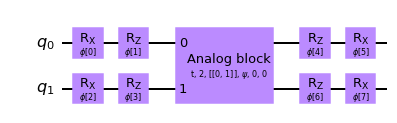

In [51]:
cirq = digital_analog_ansatz_Ising(H2_op)
cirq.draw(output="mpl")

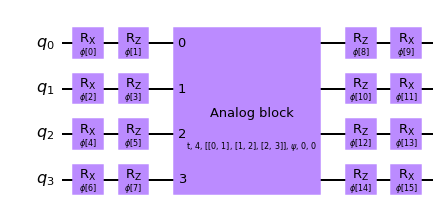

In [52]:
cirq = digital_analog_ansatz_Ising(LiH_op)
cirq.draw(output="mpl")

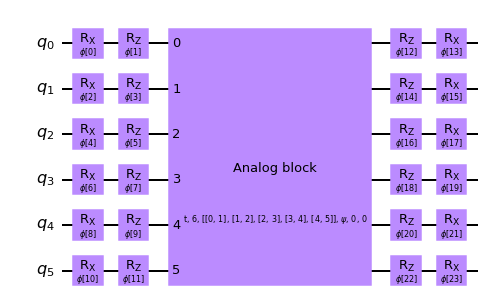

In [53]:
cirq = digital_analog_ansatz_Ising(BeH2_op)
cirq.draw(output="mpl")

In [54]:
def find_E0(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations),entanglement="entire"):
    cirq = digital_analog_ansatz_Ising(Operator, entanglement)
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP
    #hist-data
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi, include_custom=True)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    return result, hist

In [55]:
result, hist = find_E0(H2_op, np.random.uniform(low=0.5, high=2.0, size=(10,)),SLSQP(maxiter=1000))

In [56]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 215,
    'eigenstate': {'01': 1.0},
    'eigenvalue': (-1.836967771198845+0j),
    'optimal_parameters': {   Parameter(t): 3.32958908299365,
                              Parameter($\psi$): 3.3025369296037814,
                              ParameterVectorElement($\phi$[7]): 0.22044033750834263,
                              ParameterVectorElement($\phi$[6]): 1.5071188228764665,
                              ParameterVectorElement($\phi$[4]): 3.0877834946836447,
                              ParameterVectorElement($\phi$[3]): 1.633945806046649,
                              ParameterVectorElement($\phi$[2]): -0.21966506375893163,
                              ParameterVectorElement($\phi$[5]): 0.4458254286928251,
                              ParameterVectorElement($\phi$[1]): 3.195767253660849,
                              ParameterVectorElement($\phi$[0]): 3.587198658990914},
    'optimal_point': array([ 3.58719866,  3.

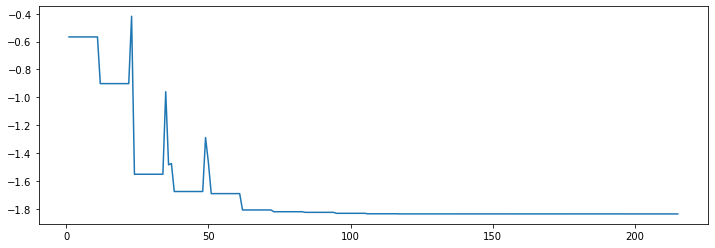

In [57]:
values, counts = hist
plt.plot(counts, values)

In [58]:
result, hist = find_E0(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(18,)),SLSQP(maxiter=1000))

In [59]:
vqe_result = LiH_problem.interpret(result).total_energies[0].real
print("Total_energy: ", vqe_result)
print("Ref: Total_energy: ", total_energy_solver(LiH_problem, LiH_converter))

Total_energy:  -7.863146987554577
Ref: Total_energy:  -7.863471722862339


In [20]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 479,
    'eigenstate': {'0101': 1.0},
    'eigenvalue': (-8.890675478764532+0j),
    'optimal_parameters': {   Parameter(t): 1.2345761455910085,
                              Parameter($\psi$): 1.2726854086971604,
                              ParameterVectorElement($\phi$[4]): 2.5556863321888916,
                              ParameterVectorElement($\phi$[13]): 0.5858335188012311,
                              ParameterVectorElement($\phi$[10]): 2.0612725566376877,
                              ParameterVectorElement($\phi$[8]): 2.155164905844755,
                              ParameterVectorElement($\phi$[11]): 0.812479439424555,
                              ParameterVectorElement($\phi$[15]): -0.0009586417062160207,
                              ParameterVectorElement($\phi$[9]): 2.0823329551767706,
                              ParameterVectorElement($\phi$[14]): 2.9639372209479578,
                              Para

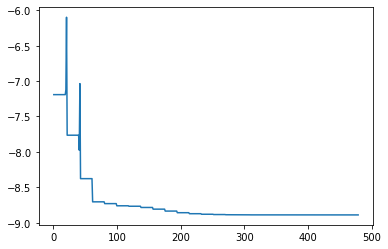

In [21]:
values, counts = hist
plt.plot(counts, values)

In [22]:
result, hist = find_E0(BeH2_op, np.random.uniform(low=0.5, high=2.0, size=(26,)),SLSQP(maxiter=1000))

In [23]:
vqe_result = BeH2_problem.interpret(result).total_energies[0].real
print("Total_energy: ", vqe_result)
print("Ref: Total_energy: ", total_energy_solver(BeH2_problem, BeH2_converter))

Total_energy:  -15.561275734008056
Ref: Total_energy:  -15.564454586481592


In [24]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 823,
    'eigenstate': {'010101': 1.0},
    'eigenvalue': (-19.021280574638826+0j),
    'optimal_parameters': {   Parameter(t): 1.4652010547928151,
                              Parameter($\psi$): 1.3376567136221162,
                              ParameterVectorElement($\phi$[6]): -1.1255048327900353e-05,
                              ParameterVectorElement($\phi$[9]): 1.6693503040041324,
                              ParameterVectorElement($\phi$[8]): -0.0030970466303819524,
                              ParameterVectorElement($\phi$[7]): 0.32031229325378724,
                              ParameterVectorElement($\phi$[15]): -0.0030150921428691146,
                              ParameterVectorElement($\phi$[17]): 1.5340162084024227,
                              ParameterVectorElement($\phi$[16]): 2.9047385794233773,
                              ParameterVectorElement($\phi$[13]): -0.0002564539667234127,
                

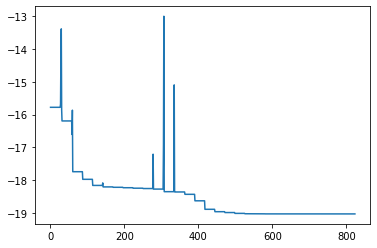

In [25]:
values, counts = hist
plt.plot(counts, values)

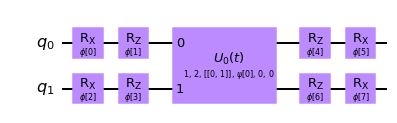

In [26]:
cirq = digital_analog_ansatz_Ising(H2_op,"staggered")
cirq.draw(output="mpl")

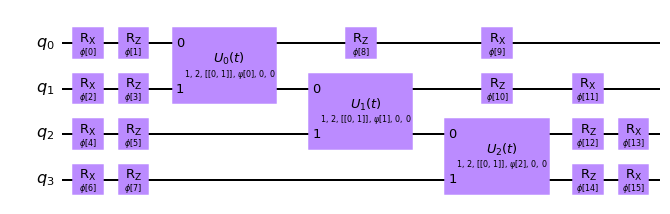

In [27]:
cirq = digital_analog_ansatz_Ising(LiH_op,"staggered")
cirq.draw(output="mpl")

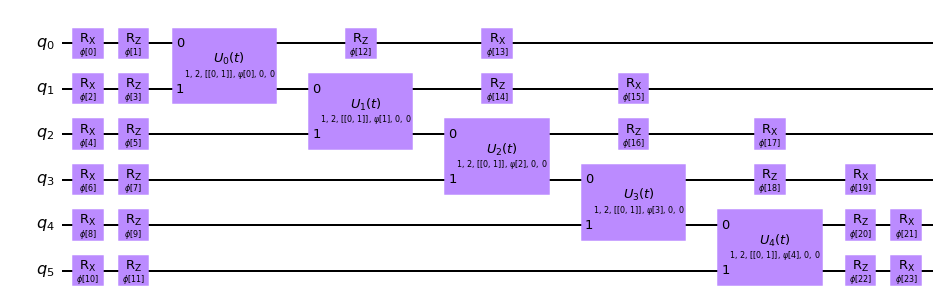

In [28]:
cirq = digital_analog_ansatz_Ising(BeH2_op,"staggered")
cirq.draw(output="mpl")

In [29]:
result, hist = find_E0(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(19,)),SLSQP(maxiter=1000),"staggered")

We captured the energy values above during the convergence so we can see what went on in the graph below.

In [30]:
vqe_result = LiH_problem.interpret(result).total_energies[0].real
print("Total_energy: ", vqe_result)
print("Ref: Total_energy: ", total_energy_solver(LiH_problem, LiH_converter))

Total_energy:  -7.863143097586674
Ref: Total_energy:  -7.863471722862355


In [31]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 507,
    'eigenstate': {'0101': 1.0},
    'eigenvalue': (-8.890671662479878+0j),
    'optimal_parameters': {   ParameterVectorElement($\phi$[0]): 2.195636415231231,
                              ParameterVectorElement($\psi$[0]): 3.2874042736447673,
                              ParameterVectorElement($\psi$[1]): 2.872391478102905,
                              ParameterVectorElement($\psi$[2]): 1.5623395478959978,
                              ParameterVectorElement($\phi$[15]): 2.851318336359711,
                              ParameterVectorElement($\phi$[14]): -0.024790294613123216,
                              ParameterVectorElement($\phi$[13]): 0.5715680379824032,
                              ParameterVectorElement($\phi$[12]): 1.1144977723619385,
                              ParameterVectorElement($\phi$[7]): 0.015002673352736695,
                              ParameterVectorElement($\phi$[3]): 1.607542007819732,

In [32]:
result, hist = find_E0(BeH2_op, np.random.uniform(low=0.5, high=2.0, size=(29,)),SLSQP(maxiter=1000),entanglement = "staggered")

In [33]:
vqe_result = BeH2_problem.interpret(result).total_energies[0].real
print("Total_energy: ", vqe_result)
print("Ref: Total_energy: ", total_energy_solver(BeH2_problem, BeH2_converter))

Total_energy:  -15.561277108266825
Ref: Total_energy:  -15.56445458648155


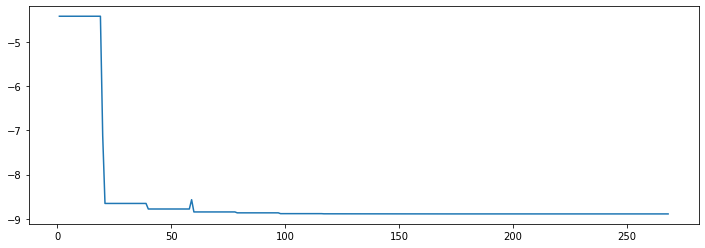

In [60]:
values, counts = hist
plt.plot(counts, values)